#Introduction and Preliminary Analysis

My goal with this project is to develop a classification pipeline that examines a player's in-game statistics in a League of Legends match and predicts the outcome of the match (Win/Loss)

##Dataset Description

The dataset, which comes directly from the League of Legends' developer, Riot Games, is seperated into seven total files. A relational database model is used to connect all '.csv' files, with each file containing important primary and foreign keys.

For this project, I will use five of the seven total files, with 'TeamMatchTbl.csv' and 'ItemTbl.csv' not being used. Both files are highly dependant on circumstances and using these features will most likely cause overfitting.

##Hypotheses

Hypothesis 1: TurretDmgDealt is the most influential feature in the dataset

Hypothesis 2: There is a postive correlation between TotalGold, DmgDealt, and kills

## Building the Dataset

To prepare our data for preprocessing, I will import the five files from Google Drive and assign each DataFrame to a variable, making it easier to combine them. I call the .info () method on each DataFrame to ensure all values and data types are loaded in correctly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Table Descriptions

####MatchStatsTbl

Contains in-game match statistics related to a particular player, such as the player's account name, amount of total gold earned, and foreign keys to other tables

In [ ]:
import pandas as pd

match_stats_table = pd.read_csv('/content/drive/MyDrive/IT7103/Project/MatchStatsTbl.csv')
match_stats_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78863 entries, 0 to 78862
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MatchStatsId          78863 non-null  int64 
 1   SummonerMatchFk       78863 non-null  int64 
 2   MinionsKilled         78863 non-null  int64 
 3   DmgDealt              78863 non-null  int64 
 4   DmgTaken              78863 non-null  int64 
 5   TurretDmgDealt        78863 non-null  int64 
 6   TotalGold             78863 non-null  int64 
 7   Lane                  78863 non-null  object
 8   Win                   78863 non-null  int64 
 9   item1                 78863 non-null  int64 
 10  item2                 78863 non-null  int64 
 11  item3                 78863 non-null  int64 
 12  item4                 78863 non-null  int64 
 13  item5                 78863 non-null  int64 
 14  item6                 78863 non-null  int64 
 15  kills                 78863 non-null

####SummonerMatchTbl

Contains information about each match played. Links together the player's account name, the ID of the match, and the champion (character) that a player chose during a particular match.

In [ ]:
summoner_match = pd.read_csv('/content/drive/MyDrive/IT7103/Project/SummonerMatchTbl.csv')
summoner_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78863 entries, 0 to 78862
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SummonerMatchId  78863 non-null  int64 
 1   SummonerFk       78863 non-null  int64 
 2   MatchFk          78863 non-null  object
 3   ChampionFk       78863 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.4+ MB


#### MatchTbl

Uses a match's ID to display statistics about the match itself, but does not contain information about any player's performance. Such statistics include the version of the game the match was played on, the type of match it was (since there are several different game modes), etc.

In [ ]:
match_table = pd.read_csv('/content/drive/MyDrive/IT7103/Project/MatchTbl.csv')
match_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35421 entries, 0 to 35420
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MatchId       35421 non-null  object
 1   Patch         35421 non-null  object
 2   QueueType     35421 non-null  object
 3   RankFk        35421 non-null  int64 
 4   GameDuration  35421 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


One thing I noticed during this process is that there are significantly less matches than there are entries in MatchStatsTbl or SummonerMatchTbl. That is because several different players can be in the same match at the same time, but each has individual performance data that is tracked. Therefore, there can be multiple entires in either of those tables for one singular match.

####ChampionTable

This table simply contains a list of the characters (known as champions) in the game and asigns each one an ID.

In [ ]:
champion_table = pd.read_csv('/content/drive/MyDrive/IT7103/Project/ChampionTbl.csv')
champion_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ChampionId    172 non-null    int64 
 1   ChampionName  172 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


All match entries choose from this list of 172 total champions. The only restriction is that each individual match cannot contain duplicates of the same champion. So if one player picks a certain champion, no other player in that particular match can choose that same champion.

####RankTbl

League of Legends features a competitive mode, where players are assigned a specific 'rank' based on their amount of wins and overall performance in this game mode. Similar to the ChampionTable, this file assigns a unique ID to each rank. The rankID is then used in the MatchStatsTbl to show a particular plyer's rank.

In [ ]:
rank_table = pd.read_csv('/content/drive/MyDrive/IT7103/Project/RankTbl.csv')
rank_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RankId    11 non-null     int64 
 1   RankName  11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes


There are 10 ranks in total along with the title of 'Unranked' for anyone who has not played the competitive game mode. Hence why there are 11 total entries. All players fall within one of these 11 ranks.

Now since the tables have been loaded, we can go ahead and merge them.

## Combining Files

To preprocess the data, we must first combine these files into one big dataset using the primary keys and foreign keys. This code simply takes the MatchStatsTbl and merges it with the other files one at a time.

In [ ]:
#Merge MatchStatsTBL with SummonerMatchTbl
merged_data = match_stats_table.merge(
    summoner_match,
    left_on='SummonerMatchFk',
    right_on='SummonerMatchId',
    how='left'
)

#Merge match stats with the match table to get patch, queuetype, gameduration, etc.
merged_data = merged_data.merge(
    match_table,
    left_on='MatchFk',
    right_on='MatchId',
    how='left'
)

#Merge data with champions table firstly to get champion name
merged_data = merged_data.merge(
    champion_table,
    left_on='ChampionFk',
    right_on='ChampionId',
    how='left'
)

#Merge again to get enemy champions
merged_data = merged_data.merge(
    champion_table,
    left_on='EnemyChampionFk',
    right_on='ChampionId',
    how='left'
)

#Merge to get rank name
merged_data = merged_data.merge(
    rank_table,
    left_on='RankFk',
    right_on='RankId',
    how='left'
)

#Rename data
merged_data.rename(columns={
    'ChampionName_x': 'ChampionName',
    'ChampionName_y': 'EnemyChampionName'
}, inplace=True)

Notice how we merged the MatchStatsTbl with the ChampionTbl twice. This is because the MatchStatsTbl contains two champion foreign keys: one for the champion the player uses and one for the champion the player faces against.

The result of this merge is a very large DataFrame containing 78863 rows and 46 columns, as shown below. However, many of these features are either IDs, foreign keys, or not relevant in achieving our goal. Only a handful of features will be used and the rest will be dropped in preprocessing.

In [ ]:
merged_data

,MatchStatsId,SummonerMatchFk,MinionsKilled,DmgDealt,DmgTaken,TurretDmgDealt,TotalGold,Lane,Win,item1,...,Patch,QueueType,RankFk,GameDuration,ChampionId_x,ChampionName,ChampionId_y,EnemyChampionName,RankId,RankName
0,1,1,30,4765,12541,0,7058,BOTTOM,0,3870,...,15.20.717.2831,CLASSIC,7,1751,902,Milio,51,Caitlyn,7,Diamond
1,2,2,29,8821,14534,1,9618,BOTTOM,0,3870,...,15.20.717.2831,CLASSIC,7,2092,902,Milio,236,Lucian,7,Diamond
2,3,3,34,6410,19011,3,9877,BOTTOM,1,3870,...,15.20.717.2831,CLASSIC,7,2332,16,Soraka,498,Xayah,7,Diamond
3,4,4,51,22206,14771,3,12374,NONE,1,6655,...,15.20.717.2831,ARAM,7,984,103,Ahri,54,Malphite,7,Diamond
4,5,5,0,39106,33572,0,15012,TOP,1,4015,...,15.20.717.2831,CHERRY,7,1541,800,Mel,12,Alistar,7,Diamond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78858,78859,78839,205,20734,19037,6,11880,TOP,1,1055,...,15.20.719.545,CLASSIC,8,1279,39,Irelia,31,Chogath,8,Master
78859,78860,78840,156,20351,23114,0,9433,NONE,0,1055,...,15.20.719.545,CLASSIC,8,1148,39,Irelia,91,Talon,8,Master
78860,78861,78841,96,7849,13337,0,4834,NONE,0,1055,...,15.20.719.545,CLASSIC,8,983,39,Irelia,56,Nocturne,8,Master
78861,78862,78842,261,22036,37949,2,14481,JUNGLE,0,6672,...,15.20.719.545,CLASSIC,8,1976,39,Irelia,62,MonkeyKing,8,Master


#Preliminary Analysis

## Filtering Features and Instances

After creating one big DataFrame, we can start dropping specific features or instances. For each step, I will explain why specific things are dropped.

### Game Mode

In League of Legends, there are many different game modes, as indicated by the "QueueType" feature. Each game mode features different gameplay, a different objective, and a different strategy to win. Trying to analyze many game modes at once is impractical and will give too much variety in the data.

Therefore, our first preprocessing step is to only analyze the "main", or most common game mode, known as "Summoner's Rift". In this DataFrame, it is indicated by using 'CLASSIC' in the 'QueueType'. We will only include instances of this game mode in the data and drop all other instances.

One thing to note is that 'CLASSIC' includes both the casual and competitive modes, commonly refered to as 'Unranked' or 'Ranked'. The only difference between the two modes is that 'Ranked' matches counts towards your overall competitive rank, while 'Unranked' does not. The gameplay, strategy, and objective remain the same in both modes.


In [ ]:
#Drop any non-classic game modes
merged_data = merged_data[merged_data['QueueType'] == 'CLASSIC']
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55262 entries, 0 to 78862
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MatchStatsId          55262 non-null  int64 
 1   SummonerMatchFk       55262 non-null  int64 
 2   MinionsKilled         55262 non-null  int64 
 3   DmgDealt              55262 non-null  int64 
 4   DmgTaken              55262 non-null  int64 
 5   TurretDmgDealt        55262 non-null  int64 
 6   TotalGold             55262 non-null  int64 
 7   Lane                  55262 non-null  object
 8   Win                   55262 non-null  int64 
 9   item1                 55262 non-null  int64 
 10  item2                 55262 non-null  int64 
 11  item3                 55262 non-null  int64 
 12  item4                 55262 non-null  int64 
 13  item5                 55262 non-null  int64 
 14  item6                 55262 non-null  int64 
 15  kills                 55262 non-null  int

### Feature Selection

After dropping non-classic game modes, we are left with about 55000 entries, which is a good size. However, there are still 46 features, which is far too many. We will need to drop quite a bit.

We can drop all IDs and Foreign keys, as those are no longer needed. That leaves us still with about 30 features. Some more can also be dropped for the following reasons:
*   **item1 - item 6**: Items are highly dependent on the champion played and the champion a player is facing. Keeping these would add too much varience in the data.
*   **Lane**: A League of Legends team has five roles, commonly known as 'lanes'. Since a match consists of two teams facing against each other, each match will have two of each role. Since one team has to be the winner of a match (there is no ties), each 'lane' will always have a 50% win rate. Therefore, the 'lane' a player is assigned to has no effect on the outcome.
*   **PrimaryKeyStone**, **PrimarySlot 1 - 3**, **SecondarySlot 1 & 2**: All of these features refer to 'runes', which are enhancements that players can select before the match starts. Like items, 'runes' are also highly dependent on the champion played and the champion a player is facing. Furthermore, while 'runes' can technically affect the outcome of the match, many of the options are personal preference and have little impact.  
*   **SummonerSpell 1 & 2**: These are additional abilities that vary based on champion played and champion faces. They are also prefernces and have little impact on the game.
* **Patch**: The 'patch', or version of the game the match was played on, may slightly affect outcomes, as champions typically have their abilities adjusted during each patch. However, I chose not to include it since players cannot chose which patch they play on.
* **QueueType**: We know the 'QueueType' is only 'CLASSIC', so there is no need to include it anymore.

After dropping all of these, we are left with the following list






In [ ]:
columns_to_keep = ['MinionsKilled', 'DmgDealt', 'DmgTaken', 'TurretDmgDealt', 'TotalGold', 'Win', 'kills', 'deaths', 'assists', 'CurrentMasteryPoints', 'DragonKills', 'BaronKills', 'visionScore', 'GameDuration', 'ChampionName', 'EnemyChampionName', 'RankName']

Using the list, we can filter out any instances we don't want. In this case, I chose to create a new DataFrame called "match_data" instead of overwritting the "merged_data" DataFrame.

In [ ]:
matchdata = merged_data[columns_to_keep]
matchdata

,MinionsKilled,DmgDealt,DmgTaken,TurretDmgDealt,TotalGold,Win,kills,deaths,assists,CurrentMasteryPoints,DragonKills,BaronKills,visionScore,GameDuration,ChampionName,EnemyChampionName,RankName
0,30,4765,12541,0,7058,0,0,2,12,902,0,0,67,1751,Milio,Caitlyn,Diamond
1,29,8821,14534,1,9618,0,2,5,23,902,0,0,88,2092,Milio,Lucian,Diamond
2,34,6410,19011,3,9877,1,0,5,22,16,0,0,97,2332,Soraka,Xayah,Diamond
6,28,3775,12061,0,6344,0,0,1,7,902,0,0,60,1676,Milio,Aphelios,Diamond
7,36,4217,13464,0,7403,0,1,5,6,267,0,0,55,1749,Nami,Ezreal,Diamond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78858,205,20734,19037,6,11880,1,6,2,6,39,0,0,11,1279,Irelia,Chogath,Master
78859,156,20351,23114,0,9433,0,9,7,1,39,0,0,9,1148,Irelia,Talon,Master
78860,96,7849,13337,0,4834,0,1,5,0,39,0,0,6,983,Irelia,Nocturne,Master
78861,261,22036,37949,2,14481,0,7,6,5,39,1,0,20,1976,Irelia,MonkeyKing,Master


We are left with 17 features, all which may have a noticible impact on the match's outcome. From here, we can begin analyzing our data and seeing if we need to do any more preprocessing

##Train-Test Split

Now that we know what columns to use, we will divide our data into a train-test split. This allows use to use 80% of our data to train the model, while 20% gets put aside to use for testing later. This also prevents us from accidental data contaimination, which is when test data accidentally leaks into the training data. Data contamination can lead to very high benchmark ratings that don't accurately reflect the model's performance.

In [ ]:
from sklearn.model_selection import train_test_split

#Define the target goal
target = 'Win'

# Create X (dataframe without target) and Y (the target)
Y = matchdata[target]
X = matchdata.drop(columns=[target])

#80% training, 20% testing
traindata_X, testdata_X, traindata_Y, testdata_Y = train_test_split(X, Y, test_size=0.2)
traindata_X.shape, testdata_X.shape, traindata_Y.shape, testdata_Y.shape

((44209, 16), (11053, 16), (44209,), (11053,))

From here, we don't need to touch the test data until the preprocessing and model pipeline is complete

##Visualization

We must first seperate the data into category columns and numeric columns. The code below puts each column in its appropriate array.

In [ ]:
import numpy as np

num_cols = [column for column in traindata_X.columns if (traindata_X[column].dtypes == np.int64) or (traindata_X[column].dtypes == np.float64)]
num_cols

['MinionsKilled',
 'DmgDealt',
 'DmgTaken',
 'TurretDmgDealt',
 'TotalGold',
 'kills',
 'deaths',
 'assists',
 'CurrentMasteryPoints',
 'DragonKills',
 'BaronKills',
 'visionScore',
 'GameDuration']

In [ ]:
cat_cols = [column for column in traindata_X.columns if traindata_X[column].dtypes == object]
cat_cols

['ChampionName', 'EnemyChampionName', 'RankName']

###Histograms

We will create a histogram for each numeric column to see if any of the data is skewed and needs to be fixed.

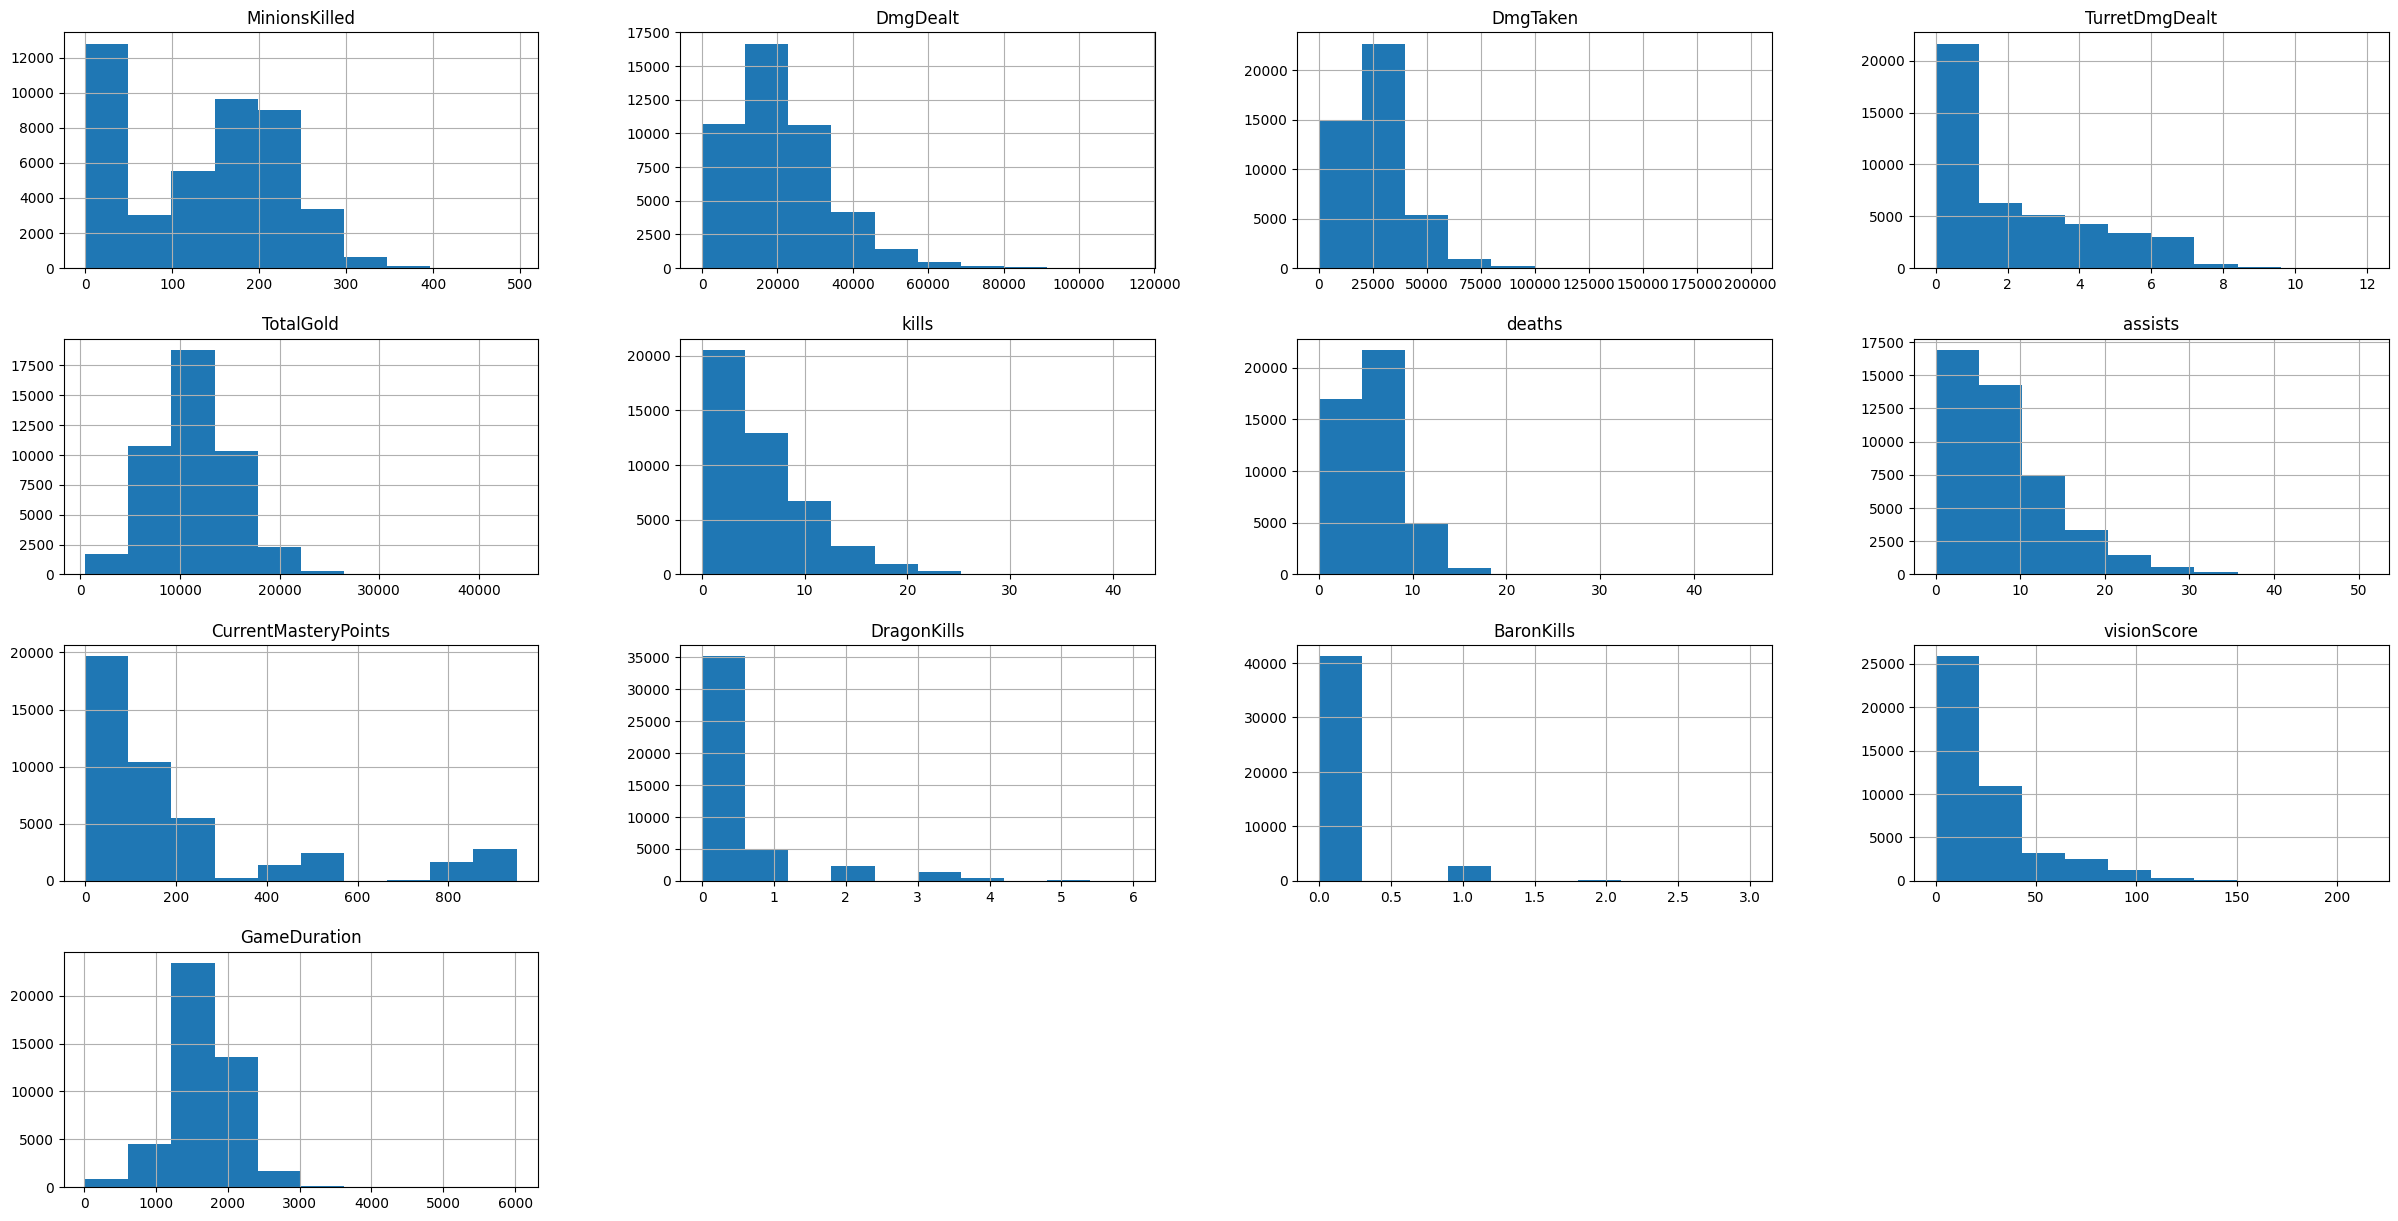

In [ ]:
from matplotlib import pyplot as plt

#Create Histogram for each numeric column
traindata_X[num_cols].hist(bins=10,figsize=(30,15))
plt.show()

We can see that a handful of columns are right-swkewed and a couple are slightly right-skewed. A log transformation will be used on the ones that are heavily skewed, while those that are slightly skewed can remain the same.

BaronKills and DragonKills are special cases due to underlying game mechanics. BaronKills will be binarized. DragonKills will be capped at 4

###Bar Charts

For the non-numeric columns, we will use bar charts to visualize the data.

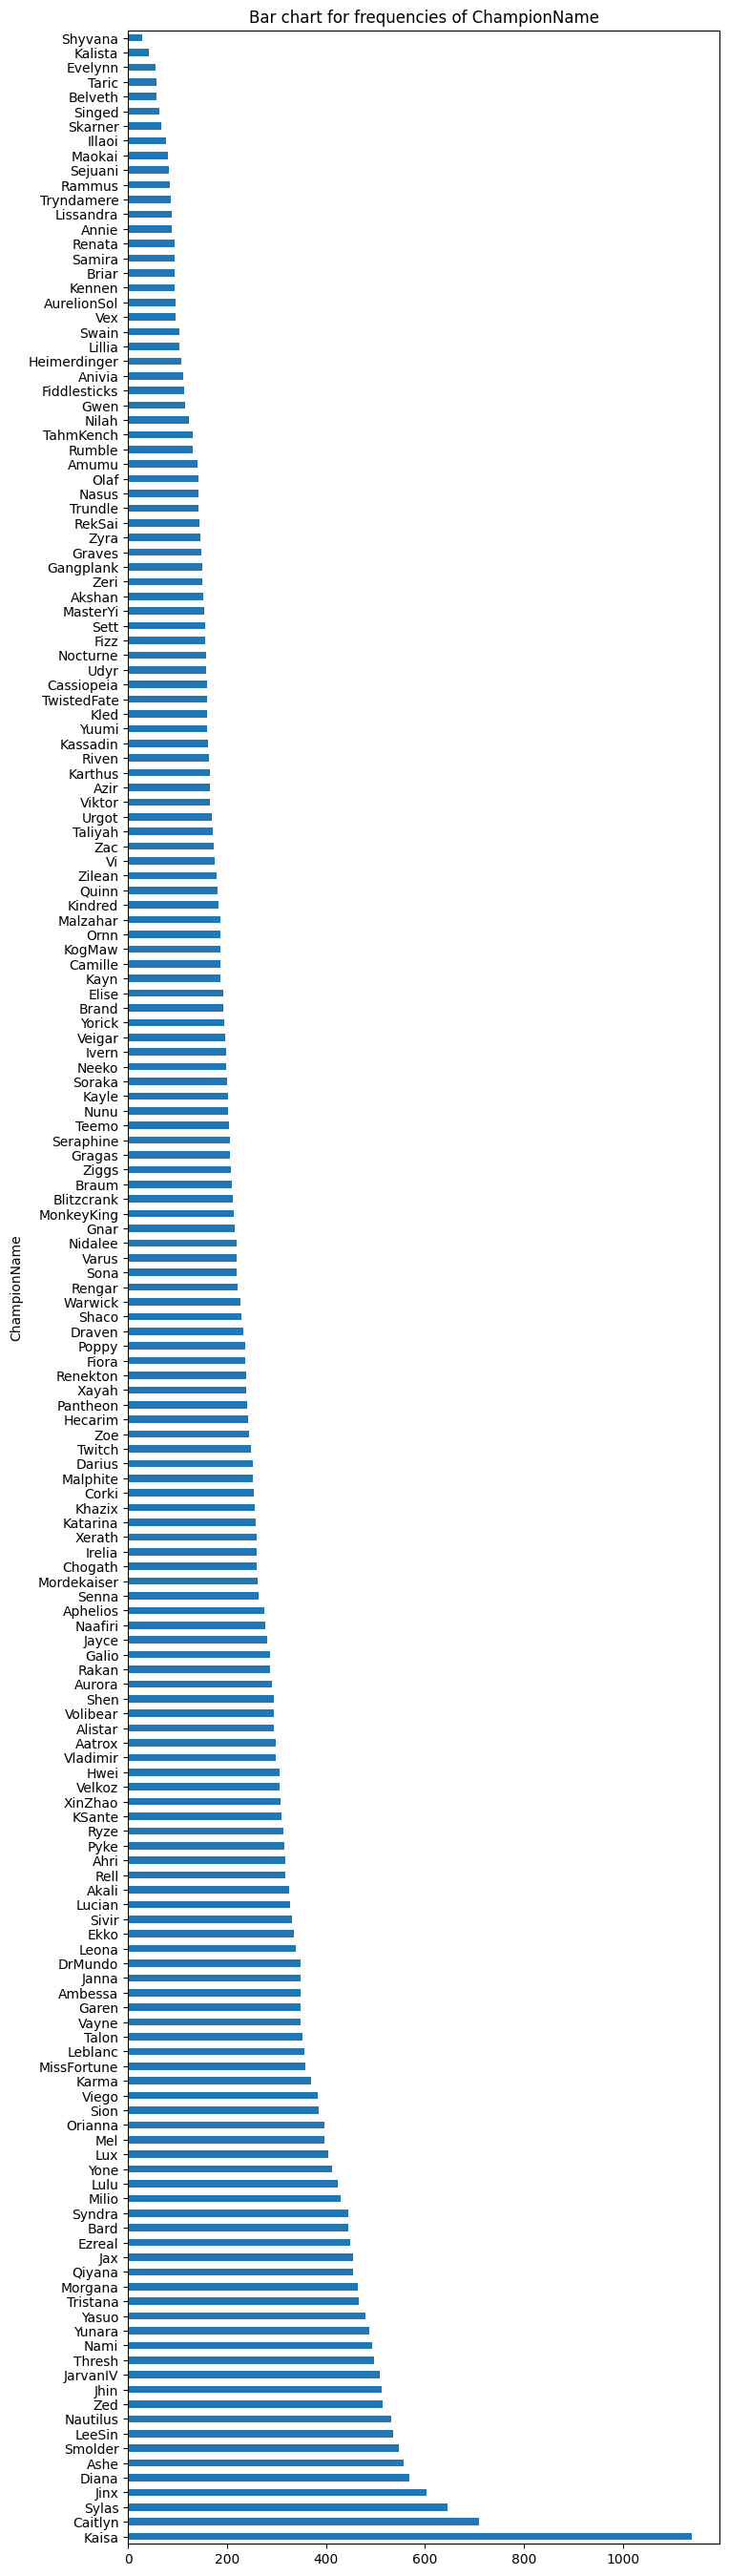

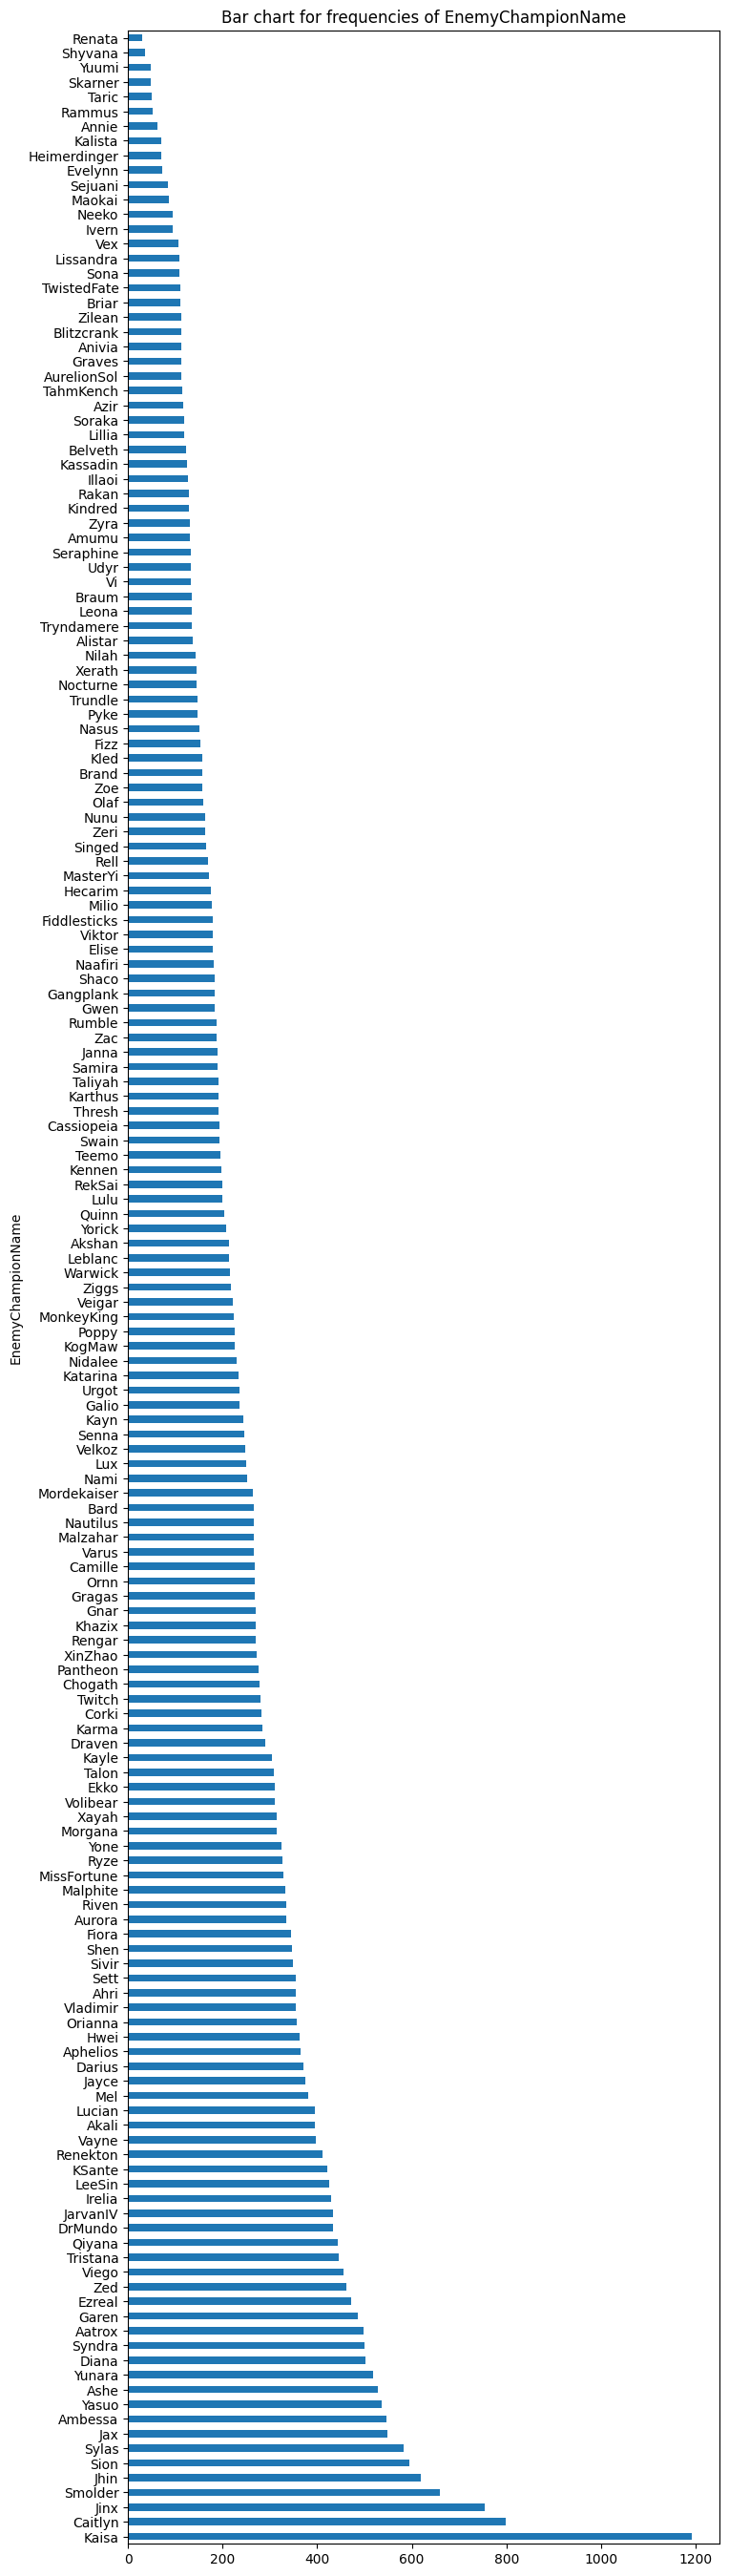

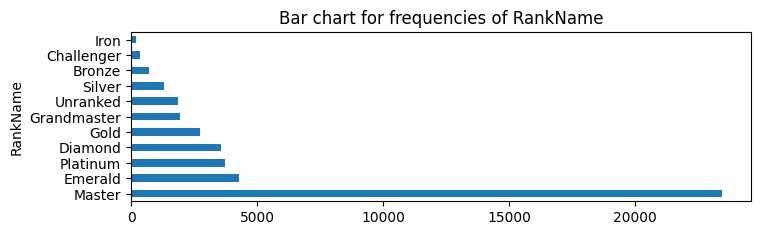

In [ ]:
for col in cat_cols:
    freq_table = traindata_X[col].value_counts()
    plt.figure(figsize = (8,len(freq_table)*0.2)) #a bit formatting so that chart look better
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

Both ChampionName and EnemyChampionName have a large amount of categories since there are 172 champions in the game. Using TargetEncoder instead of OneHotEncoder

RankName only has 11 categories, OneHot Encoder will work

###Correlation

**Hypothesis 2:** Positive correlation between TotalGold, DmgDealt, and kills

Creating correlation heatmap before transformation to view correlations

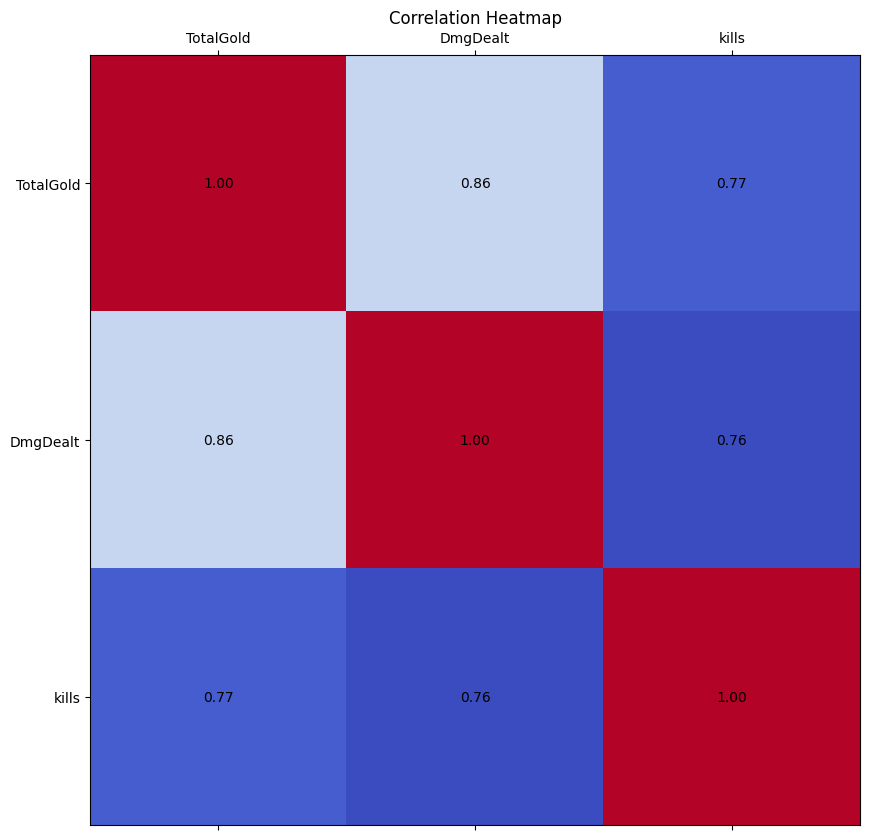

In [ ]:
# Correlation Matrix
corr_features = ['TotalGold', 'DmgDealt', 'kills']
corr_matx = traindata_X[corr_features].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(corr_matx, cmap='coolwarm')

# Axis labels
ax.set_xticks(range(len(corr_features)))
ax.set_yticks(range(len(corr_features)))
ax.set_xticklabels(corr_features)
ax.set_yticklabels(corr_features)

for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        text = ax.text(j, i, f"{corr_matx.iloc[i,j]:.2f}",
                       va="center", ha="center", color="black")

plt.title('Correlation Heatmap')
plt.show()

High correlation coefficients: **Supports Hypothesis 2**

# Data Preprocessing

Seperate data into respective transformation lists

In [ ]:
symm_cols = ['MinionsKilled', 'DmgDealt', 'DmgTaken', 'TotalGold', 'GameDuration'] # Symmetric Numeric Columns
log_cols = ['TurretDmgDealt', 'kills', 'deaths', 'assists', 'CurrentMasteryPoints', 'visionScore'] # Skewed Numeric Columns
bin_cols = ['BaronKills'] #To be converted into 1 - slain baron, or 0 - has not slain baron
cap_cols = ['DragonKills'] #To be capped at 4
cat_onehot_cols = ['RankName'] # Category Columns to use with OneHot Encoder
cat_targetencoder_cols = ['ChampionName', 'EnemyChampionName'] # Category Columns to use with TargetEncoder

###Imputation

Prior to the pipeline, the data is checked for imputation.

In [ ]:
traindata_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44209 entries, 17699 to 64674
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MinionsKilled         44209 non-null  int64 
 1   DmgDealt              44209 non-null  int64 
 2   DmgTaken              44209 non-null  int64 
 3   TurretDmgDealt        44209 non-null  int64 
 4   TotalGold             44209 non-null  int64 
 5   kills                 44209 non-null  int64 
 6   deaths                44209 non-null  int64 
 7   assists               44209 non-null  int64 
 8   CurrentMasteryPoints  44209 non-null  int64 
 9   DragonKills           44209 non-null  int64 
 10  BaronKills            44209 non-null  int64 
 11  visionScore           44209 non-null  int64 
 12  GameDuration          44209 non-null  int64 
 13  ChampionName          44209 non-null  object
 14  EnemyChampionName     44209 non-null  object
 15  RankName              44209 non-null 

In [ ]:
traindata_Y.info()

<class 'pandas.core.series.Series'>
Index: 44209 entries, 17699 to 64674
Series name: Win
Non-Null Count  Dtype
--------------  -----
44209 non-null  int64
dtypes: int64(1)
memory usage: 690.8 KB


No values are missing, so imputation is not required

###Target Class Balance

The target class is checked for imbalance for values

In [ ]:
traindata_Y.value_counts()

,count
Win,
1,22441
0,21768


There is an equal balance of Win (1) and Loss (0)

## Preprocessing Pipeline

We have looked at each column and determine which steps to take to make it more suitible for our model.

Now, we can write the pipeline to modify each column

In [ ]:
#Processing Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Install for TargetEncoder
!pip install category_encoders
from category_encoders import TargetEncoder

#Symmetric Numeric Pipeline
symm_pipeline = Pipeline([
    ('standardize', StandardScaler()) #Scale all numeric columns
])

#Log Transformation
def log_transformation(x):
  return np.log1p(x)

#Log Pipeline for Skewed Data
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(log_transformation)), #Log Transformation for skewed data
    ('standardize', StandardScaler()) #Scale all numeric columns
])

#Binary Pipeline for num cols
def binarze(X):
  return (X > 0).astype(int)

binary_pipeline = Pipeline([
    ('binarize', FunctionTransformer(binarze)), #Binarize BaronKills
    ('standardize', StandardScaler()) #Scale all numeric columns
])

#Capped Pipeline for DragonKills
def cap_values(x):
  return np.clip(x, None, 4)

capped_pipeline = Pipeline([
    ('cap', FunctionTransformer(cap_values)), #Cap DragonKills
    ('standardize', StandardScaler()) #Scale all numeric columns
])

#Merge the numeric and category columns
processing_pipeline = ColumnTransformer([
    ('symm', symm_pipeline, symm_cols), #Numeric Columns
    ('log', log_pipeline, log_cols), #Log columns
    ('binary', binary_pipeline, bin_cols), #Binary columns
    ('capped', capped_pipeline, cap_cols), #Capped columns
    ('onehot', OneHotEncoder(max_categories=11, handle_unknown='infrequent_if_exist'), cat_onehot_cols), #OneHot categories
    ('target', TargetEncoder(cols=cat_targetencoder_cols), cat_targetencoder_cols) #Target Categories
])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00


Processing_pipeline is ready to use with our model

#Model Selection, Training, and Hyperparameter Search

For the model selection, I have chosen the following models:
* Logistic Regression
* RandomForestClassifier
* MLP Classifier

A description can be found in each model's section

##Model Training (No fine-tuning)

First, we will train all three models without fine tuning them. This is to get a base understanding of how each model performs and see if any adjustments are needed. After each one, we will check the cross_val_score with cv=5

###Logistic Regression

Logistic Regression is a common classification model that uses the Sigmoid function and a threshold to predict the probability of data belonging to class 1. In this case, we can use the model to predict the outcome of a match as a Win (1) or a Loss (0).

One of the benefits of Logistic Regression is that it treats all features as independent variables and creates coefficients for each feature to determine that feature's weight, or impact in the prediction. We will see this later on.

To train our model, we will combine our preprocessing and model into one singular pipeline. We can then fit the traindata with our target.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Model Pipeline
logistic_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('model', LogisticRegression(max_iter=5000, solver='saga'))
])

# Cross val score
logistic_scores_noft = cross_val_score(logistic_pipeline, traindata_X, traindata_Y, cv=5)
print("Logistic Regression Score (no fine-tune): ", logistic_scores_noft.mean())

Logistic Regression Score (no fine-tune):  0.858648606212839


###MLP Classifier

The MLPClassifier is a neural network used to perform classification. By using a neural network model, we can identify correlations between several different features and predict the outcome of a match in a non-linear fashion.

In [ ]:
from sklearn.neural_network import MLPClassifier

# Model Pipeline
neural_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('model', MLPClassifier(max_iter=2000))
])

# Cross val score
neural_scores_noft = cross_val_score(neural_pipeline, traindata_X, traindata_Y, cv=5)
print("Neural Network Score (no fine-tune): ", neural_scores_noft.mean())

Neural Network Score (no fine-tune):  0.8774456627901184


###RandomForestClassifier

A RandomForestClassifier is simply a group of decision trees trained on different random subsets of data. This model is beneficial because it is very resillient to overfitting and can also be used to determine the most influential features in a dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Model Pipeline
forest_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('model', RandomForestClassifier())
])

# Score val score
forest_scores_noft = cross_val_score(forest_pipeline, traindata_X, traindata_Y, cv=5)
print("Random Forest Score (no fine-tune): ", forest_scores_noft.mean())

Random Forest Score (no fine-tune):  0.93928836676584


### Pre-fine-tuning results

For not fine-tuning any of the three models, our cross_val_scores are quite accurate. Now, we can see if fine-tuning any of our models improves the accuracy even more

## Fine-tuning Models

To fine-tune our models, we will use GridSearchCV to find the best possible hyper-parameters.

### Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

#Parameeters for Logistic Regression
logistic_params = [
    {'model__penalty' : ['l2', 'l1'],                        #grid for penalty = l2 and penalty = l1
     'model__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'model__penalty' : ['elasticnet'],                      #grid for penalty = enet
     'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
     'model__l1_ratio' : [0.1, 0.25, 0.5, 0.75, 0.9]}
]

logistic_regression_ft = GridSearchCV(logistic_pipeline, logistic_params, cv=5, scoring='accuracy', return_train_score=True)
logistic_regression_ft.fit(traindata_X, traindata_Y)
print("Best Score: ", logistic_regression_ft.best_score_)


Best Score:  0.8589652920001327


We can use the following code to see the best hyper-parameters

In [ ]:
print("Best params:", logistic_regression_ft.best_params_)

Best params: {'model__C': 10, 'model__penalty': 'l1'}


### MLP Classifier

In [ ]:
from sklearn.base import clone

#Due to preprocessing, we need to make a copy of our processing pipeline to get the number of features
temp_processing = clone(processing_pipeline)

#Get number of input features
n_features = temp_processing.fit_transform(traindata_X, traindata_Y).shape[1]

#Parameter grid for Neural Network
neural_grid = [{
    'model__hidden_layer_sizes' : [(n_features,n_features),                       #two hidden layer with n_features neurons
                                (n_features,n_features,n_features),            #three hidden layer with n_features neurons
                                (n_features//2,n_features//2),                 #two hidden layer with n_features/2 neurons
                                (n_features//2,n_features//2,n_features//2),   #three hidden layer with n_features/2 neurons
                                (n_features*2,n_features*2),                   #two hidden layer with n_features*2 neurons
                                (n_features*2,n_features*2,n_features*2)],     #three hidden layer with n_features*2 neurons
    'model__alpha' : [0.001, 0.01, 0.1, 1, 10]                                    #regularization terms
}]

neural_model_ft = GridSearchCV(neural_pipeline, neural_grid, cv=5, scoring='accuracy', return_train_score=True)
neural_model_ft.fit(traindata_X, traindata_Y)
print("Best Score: ", neural_model_ft.best_score_)

Best Score:  0.891605662182229


Using the same code as earlier, we can find out the best parameters for the MLP Classifier

In [ ]:
print("Best params:", neural_model_ft.best_params_)

Best params: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (52, 52, 52)}


### RandomForestClassifier

In [ ]:
#We can reuse n_features from earlier, but still need data size for params
data_size = traindata_X.shape[0]

#Parameter grid for Random Forest
forest_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

forest_model_ft = GridSearchCV(forest_pipeline, forest_grid, cv=5, scoring='accuracy', return_train_score=True)
forest_model_ft.fit(traindata_X, traindata_Y)
print("Best Score: ", forest_model_ft.best_score_)


Best Score:  0.9396503116545819


We can also check and see what the best parameters are for this model.

In [ ]:
print("Best params:", forest_model_ft.best_params_)

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


##Getting Best Models

In [ ]:
#Create a new model var with the best estimator of each model
best_neural_model = neural_model_ft.best_estimator_
best_logistic_model = logistic_regression_ft.best_estimator_
best_forest_model = forest_model_ft.best_estimator_

#Evaluation, Results, and Analysis

Now that all models have been trained, we can predict the Win/Loss of a League of Legends match using the test data. We can also evaluate the scores of each model.

In [ ]:
#Predict the match outcome using each model
neural_win_predict = best_neural_model.predict(testdata_X)
logistic_win_predict = best_logistic_model.predict(testdata_X)
forest_win_predict = best_forest_model.predict(testdata_X)

##Accuracy, Precision, Recall, F1 Scores

Now that we predicted the test data, we can check the scores of each model.

###Logistic Regression

Accuracy:  0.8554238668234868
Precision:  0.8601423487544484
Recall:  0.8561813673397095
F1 Score:  0.8581572874134564


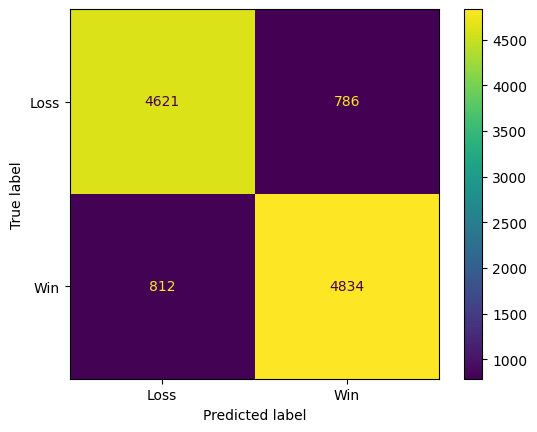

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay

print("Accuracy: ", accuracy_score(testdata_Y, logistic_win_predict))
print("Precision: ", precision_score(testdata_Y, logistic_win_predict))
print("Recall: ", recall_score(testdata_Y, logistic_win_predict))
print("F1 Score: ", f1_score(testdata_Y, logistic_win_predict))

logistic_cm = confusion_matrix(testdata_Y, logistic_win_predict)
logistic_cm_display = ConfusionMatrixDisplay(logistic_cm, display_labels=['Loss','Win'])
logistic_cm_display.plot()


### MLP Classifier

Accuracy:  0.9046412738622999
Precision:  0.9266072092159049
Recall:  0.8832801983705278
F1 Score:  0.9044250997461009


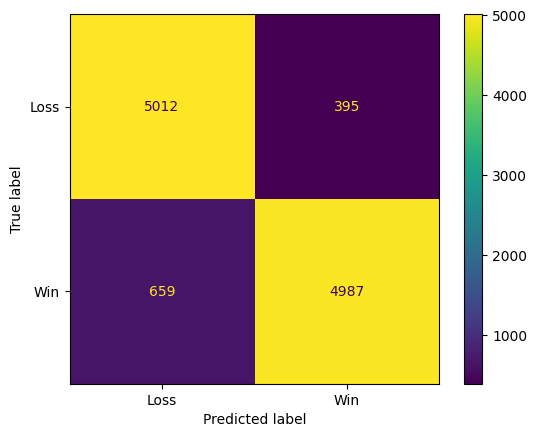

In [ ]:
print("Accuracy: ", accuracy_score(testdata_Y, neural_win_predict))
print("Precision: ", precision_score(testdata_Y, neural_win_predict))
print("Recall: ", recall_score(testdata_Y, neural_win_predict))
print("F1 Score: ", f1_score(testdata_Y, neural_win_predict))

neural_cm = confusion_matrix(testdata_Y, neural_win_predict)
neural_cm_display = ConfusionMatrixDisplay(neural_cm, display_labels=['Loss','Win'])
neural_cm_display.plot()


### RandomForestClassifier

Accuracy:  0.9597394372568533
Precision:  0.9646239056637484
Recall:  0.9562522139567836
F1 Score  0.9604198167748822


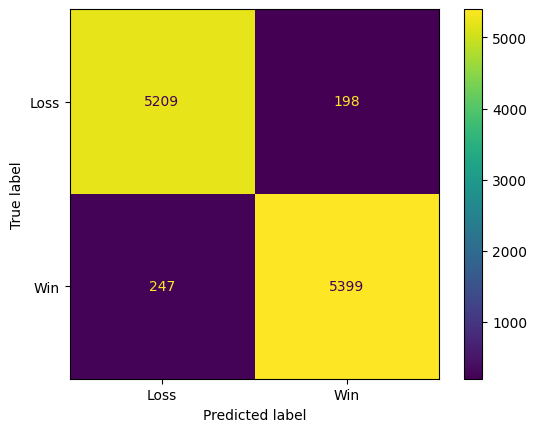

In [ ]:
print("Accuracy: ", accuracy_score(testdata_Y, forest_win_predict))
print("Precision: ", precision_score(testdata_Y, forest_win_predict))
print("Recall: ", recall_score(testdata_Y, forest_win_predict))
print("F1 Score ", f1_score(testdata_Y, forest_win_predict))

forest_cm = confusion_matrix(testdata_Y, forest_win_predict)
forest_cm_display = ConfusionMatrixDisplay(forest_cm, display_labels=['Loss','Win'])
forest_cm_display.plot()

##Results

All three models performed well and are suitable for the problem, but I recommend RandomForestClassifier as it performed the best of the three.

##Analysis

My first hypothesis claimed that TurretDmgDealt has the most impact on winning. In order to see if this is true, I will analyze the weights of both the LinearRegression model and RandomForestClassifier model.

### LogisticRegression Weights

First I will need to get the coefficients of the model and the feature names. Feature names will require extra code due to the nature of the various transformation

In [ ]:
#Get coeffs of model
coefs = best_logistic_model.named_steps['model'].coef_.flatten()

#Function to get feature names
ct = best_logistic_model.named_steps["processing"]

feature_names = []

#Loop through all transformers in ColumnTransfrmer
for name, transformer, columns in ct.transformers_:
    print(f"\n--- {name} ---")
    print("Columns:", columns)
    print("Transformer:", transformer)

    if transformer == 'drop' or transformer == 'passthrough':
      #passthrough keeps original column names
      feature_names.extend(columns)
    else:
        #If the transformer has get_feature_names_out (like OneHotEncoder or StandardScaler in v1.0+)
        try:
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names)
        except:
            #Fallback: just use the original column names
            feature_names.extend(columns)


--- symm ---
Columns: ['MinionsKilled', 'DmgDealt', 'DmgTaken', 'TotalGold', 'GameDuration']
Transformer: Pipeline(steps=[('standardize', StandardScaler())])

--- log ---
Columns: ['TurretDmgDealt', 'kills', 'deaths', 'assists', 'CurrentMasteryPoints', 'visionScore']
Transformer: Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transformation at 0x7acb6b2edf80>)),
                ('standardize', StandardScaler())])

--- binary ---
Columns: ['BaronKills']
Transformer: Pipeline(steps=[('binarize',
                 FunctionTransformer(func=<function binarze at 0x7acb6b2ee700>)),
                ('standardize', StandardScaler())])

--- capped ---
Columns: ['DragonKills']
Transformer: Pipeline(steps=[('cap',
                 FunctionTransformer(func=<function cap_values at 0x7acb68af8540>)),
                ('standardize', StandardScaler())])

--- onehot ---
Columns: ['RankName']
Transformer: OneHotEncoder(handle_unknown='infrequent_if_exist', max_c

Once we get the features names and coefficients, we can visualize it.

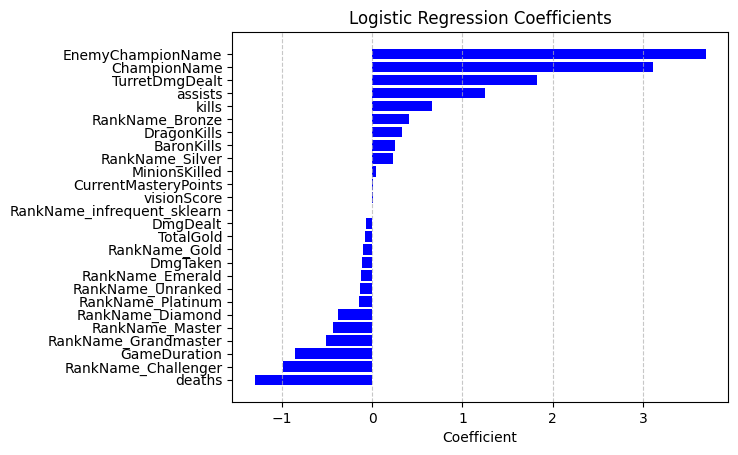

In [ ]:
#Create series with logreg coeefs and names
coef_series = pd.Series(coefs, index=feature_names).sort_values(ascending=False)

#Plot logreg coeefs
plt.barh(coef_series.index, coef_series.values, color='blue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()
plt.show()


###Random Forest Evalulation

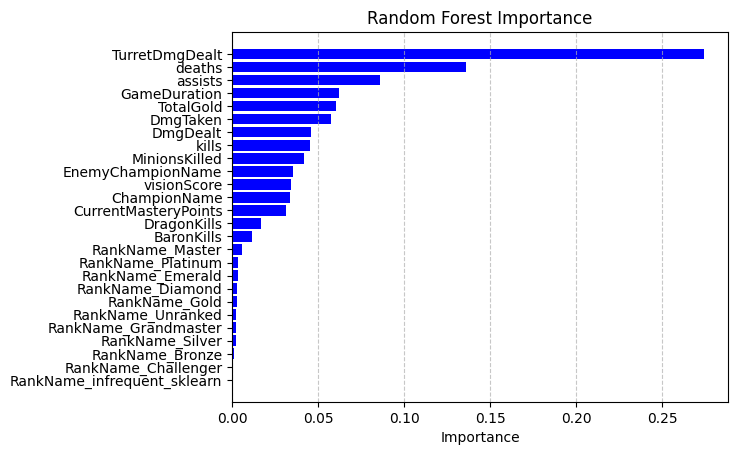

In [ ]:
#Create series with randomforest
rf_coeffs = best_forest_model.named_steps['model'].feature_importances_

rf_coef_series = pd.Series(rf_coeffs, index=feature_names).sort_values(ascending=False)

#Plot randomforest coeefs
plt.barh(rf_coef_series.index, rf_coef_series.values, color='blue')
plt.xlabel('Importance')
plt.title('Random Forest Importance')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()
plt.show()



RandomForest only shows the importance of each feature, while LogisticRegression shows us the direction in which a feature impacts the outcome. Negative correlations a loss while positive correlates to a win

There is a discrepancy in kills, TotalGold, and DmgDealt between Linear Regression and Random Forest. It is likely that these 3 features are correlated and Logistic Regression assigned them a suboptimal weight.

#Conclusion

RandomForestClassifier is the recommended model for this problem. It achieved over 95% accuracy for both training and testing.

Players who focus on taking turret, dying less, and assisting with enemy takedowns are more likely to win their matches. This gives players a solid strategy to focus on.

Evidence supports that Hypothesis 1 is correct, as both analyses show TurretDmgDealt as the most impactful feature.

While the pre-transformation visualizations show a positive correlation between TotalGold, DmgDealt, and kills, the Logistic Regression Coefficients suggest otherwise.

However, Logistic Regression had the worst accuracy of the 3 models, so these features could have been assigned a sub-optimal weight